In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

data = pd.concat([train_df, test_df], ignore_index=True)

data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify the target variable
categorical_target = 'attack_cat'
binary_target = 'label'

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the target variable
if categorical_target in data.columns:
    data[categorical_target] = label_encoder.fit_transform(data[categorical_target])

# Apply label encoding to each categorical feature
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to numerical features excluding the target variables
features_to_scale = data.columns.difference([categorical_target, binary_target])
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM, MultiHeadAttention, GlobalAveragePooling1D



# Assume 'binary_target' and 'multi_class_target' are the names of the target variables
X = data.drop(columns=['label', 'attack_cat'])
y_binary = data['label']
y_multi_class = data['attack_cat']

In [ ]:
# Train-test split
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X, y_binary, y_multi_class, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for CNN 1D input
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

CNN + LSTM + Attention Mechanism


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, LSTM, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=2, key_dim=50)(x, x)
attention_output = Add()([x, attention_output])
attention_output = LayerNormalization()(attention_output)

# Flatten and Dense layers for classification
x = GlobalAveragePooling1D()(attention_output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelLSTM_A = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
modelLSTM_A.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelLSTM_A.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)


Epoch 1/5
5154/5154 [==============================] - 159s 30ms/step - loss: 1.0510 - binary_output_loss: 0.2378 - multi_class_output_loss: 0.8132 - binary_output_accuracy: 0.8868 - multi_class_output_accuracy: 0.7009 - val_loss: 0.7970 - val_binary_output_loss: 0.1609 - val_multi_class_output_loss: 0.6362 - val_binary_output_accuracy: 0.9239 - val_multi_class_output_accuracy: 0.7573
Epoch 2/5
5154/5154 [==============================] - 148s 29ms/step - loss: 0.8277 - binary_output_loss: 0.1690 - multi_class_output_loss: 0.6588 - binary_output_accuracy: 0.9194 - multi_class_output_accuracy: 0.7558 - val_loss: 0.7451 - val_binary_output_loss: 0.1472 - val_multi_class_output_loss: 0.5980 - val_binary_output_accuracy: 0.9331 - val_multi_class_output_accuracy: 0.7807
Epoch 3/5
5154/5154 [==============================] - 147s 29ms/step - loss: 0.7679 - binary_output_loss: 0.1521 - multi_class_output_loss: 0.6158 - binary_output_accuracy: 0.9295 - multi_class_output_accuracy: 0.7720 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelLSTM_A.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 16s 9ms/step
Binary Classification:
Accuracy: 0.9502862132531289
Precision: 0.9401530967292971
Recall: 0.9848733369783124
F1 Score: 0.961993769470405
Confusion Matrix:
[[16549  2064]
 [  498 32424]]

Multi-Class Classification:
Accuracy: 0.8090812069467352
Precision: 0.799553363495037
Recall: 0.8090812069467352
F1 Score: 0.7796888109010796
Confusion Matrix:
[[    0     0     0   438     2     0    74     5     0     0]
 [    0     0     0   431    12     0     1    24     0     0]
 [    0     0     1  3096    71     3    30    91     0     0]
 [    0     0     1  8564   326     3    76   110     0     0]
 [    0     0     0   850  3236     1   563   181     0     0]
 [    0     0     0   238    52 11221     7    19     0     0]
 [    0     0     0   292  1231     1 16989   100     0     0]
 [    0     0     0  1023    91     0    53  1685     0     0]
 [    0     0     0    87    45     0    11   166     0     0]
 [    0     0     0    31   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


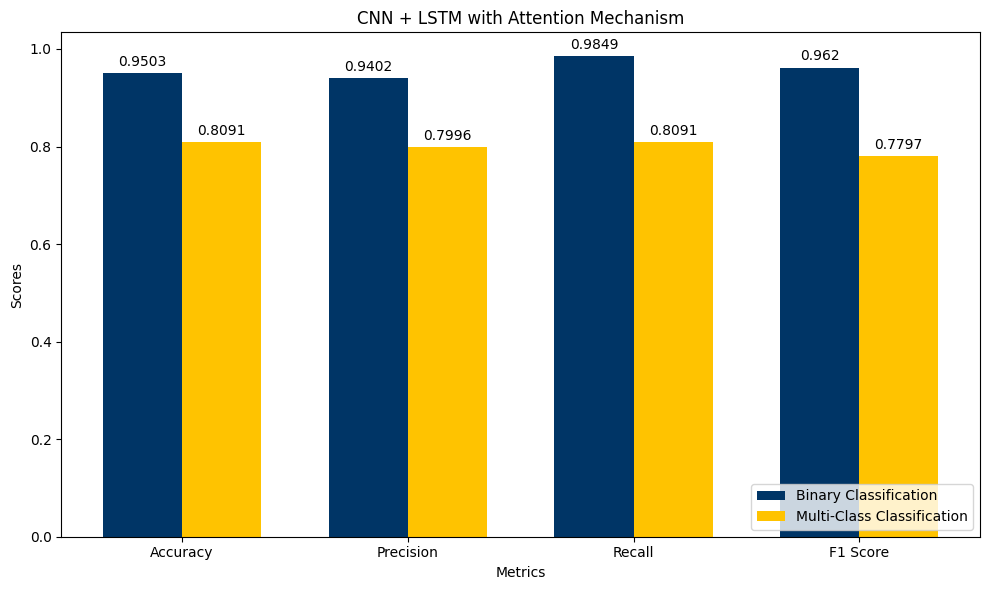

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + LSTM with Attention Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+BiLSTM

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# BiLSTM for sequence modeling
x = Bidirectional(LSTM(50, return_sequences=True))(x)

# Multi-head attention layer
attention_output, attention_weights = MultiHeadAttention(num_heads=8, key_dim=50)(x, x, return_attention_scores=True)
x = GlobalAveragePooling1D()(attention_output)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiLSTM_A = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
modelBiLSTM_A.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelBiLSTM_A.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 [==============================] - 323s 62ms/step - loss: 1.0288 - binary_output_loss: 0.2331 - multi_class_output_loss: 0.7957 - binary_output_accuracy: 0.8897 - multi_class_output_accuracy: 0.7052 - val_loss: 0.7726 - val_binary_output_loss: 0.1573 - val_multi_class_output_loss: 0.6154 - val_binary_output_accuracy: 0.9261 - val_multi_class_output_accuracy: 0.7696
Epoch 2/5
5154/5154 [==============================] - 335s 65ms/step - loss: 0.8126 - binary_output_loss: 0.1676 - multi_class_output_loss: 0.6449 - binary_output_accuracy: 0.9210 - multi_class_output_accuracy: 0.7594 - val_loss: 0.7324 - val_binary_output_loss: 0.1459 - val_multi_class_output_loss: 0.5865 - val_binary_output_accuracy: 0.9297 - val_multi_class_output_accuracy: 0.7771
Epoch 3/5
5154/5154 [==============================] - 337s 65ms/step - loss: 0.7635 - binary_output_loss: 0.1548 - multi_class_output_loss: 0.6087 - binary_output_accuracy: 0.9275 - multi_class_output_accuracy: 0.7719 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiLSTM_A.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 51s 31ms/step
Binary Classification:
Accuracy: 0.9448918210924614
Precision: 0.9679255848680935
Recall: 0.9450519409513395
F1 Score: 0.9563520118033996
Confusion Matrix:
[[17582  1031]
 [ 1809 31113]]

Multi-Class Classification:
Accuracy: 0.8030270689822451
Precision: 0.7873139377959375
Recall: 0.8030270689822451
F1 Score: 0.7769584074878498
Confusion Matrix:
[[    4     0    39   376    27     0    70     3     0     0]
 [    0     0    39   365    30     0     9    25     0     0]
 [    0     0   421  2667    53     4    53    89     5     0]
 [    2     0   420  8030   234     1   211   172    10     0]
 [    0     0    63   651  2007     0  1925   183     2     0]
 [    0     0    21   221    24 11224    29    17     1     0]
 [    1     0     1   279   315     0 17954    59     4     0]
 [    0     0    63   859    50     0   182  1698     0     0]
 [    0     0     0    36    16     0    53   158    46     0]
 [    0     0     0    33

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


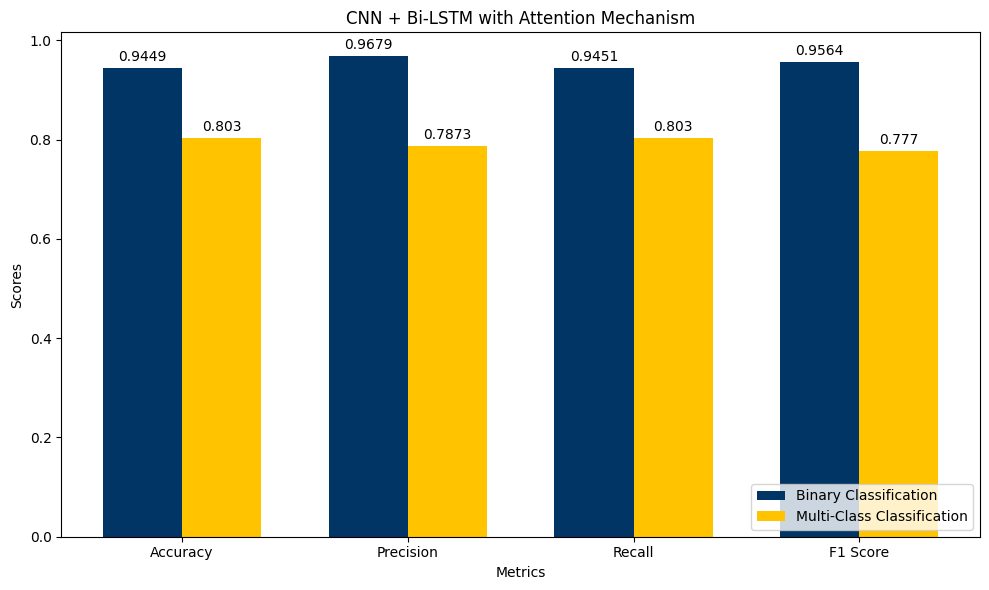

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM with Attention Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+GRU with Attention Mechanism 02


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, GRU, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# GRU for sequence modeling
x = GRU(50, return_sequences=True)(x)

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=2, key_dim=50)(x, x)
attention_output = Add()([x, attention_output])
attention_output = LayerNormalization()(attention_output)

# Flatten and Dense layers for classification
x = GlobalAveragePooling1D()(attention_output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelGRU_A = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])


In [ ]:
# Compile the model
modelGRU_A.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)


In [ ]:
# Train the model
modelGRU_A.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=8, batch_size=32, validation_split=0.2
)


Epoch 1/8
5154/5154 [==============================] - 158s 30ms/step - loss: 1.0562 - binary_output_loss: 0.2401 - multi_class_output_loss: 0.8161 - binary_output_accuracy: 0.8877 - multi_class_output_accuracy: 0.6985 - val_loss: 0.8068 - val_binary_output_loss: 0.1682 - val_multi_class_output_loss: 0.6386 - val_binary_output_accuracy: 0.9242 - val_multi_class_output_accuracy: 0.7608
Epoch 2/8
5154/5154 [==============================] - 137s 27ms/step - loss: 0.8124 - binary_output_loss: 0.1647 - multi_class_output_loss: 0.6477 - binary_output_accuracy: 0.9220 - multi_class_output_accuracy: 0.7593 - val_loss: 0.7210 - val_binary_output_loss: 0.1424 - val_multi_class_output_loss: 0.5786 - val_binary_output_accuracy: 0.9343 - val_multi_class_output_accuracy: 0.7801
Epoch 3/8
5154/5154 [==============================] - 151s 29ms/step - loss: 0.7560 - binary_output_loss: 0.1499 - multi_class_output_loss: 0.6061 - binary_output_accuracy: 0.9308 - multi_class_output_accuracy: 0.7766 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelGRU_A.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 12s 7ms/step
Binary Classification:
Accuracy: 0.9512952362472107
Precision: 0.9670721218822951
Recall: 0.9563210011542433
F1 Score: 0.9616665139436146
Confusion Matrix:
[[17541  1072]
 [ 1438 31484]]

Multi-Class Classification:
Accuracy: 0.8100320170757738
Precision: 0.7874628711795947
Recall: 0.8100320170757738
F1 Score: 0.7768122815396976
Confusion Matrix:
[[    0     0    11   418     2     0    83     5     0     0]
 [    0     0     7   417     4     0     8    32     0     0]
 [    0     0    78  3013    51     3    43   103     1     0]
 [    0     0    70  8394   175     3   192   246     0     0]
 [    0     0    10   848  2306     3  1490   174     0     0]
 [    0     0     8   243    32 11226    10    18     0     0]
 [    0     0     0   188   433     1 17890    99     2     0]
 [    0     0    21   820    45     1   119  1846     0     0]
 [    0     0     0    66    26     0    25   187     5     0]
 [    0     0     0    33 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


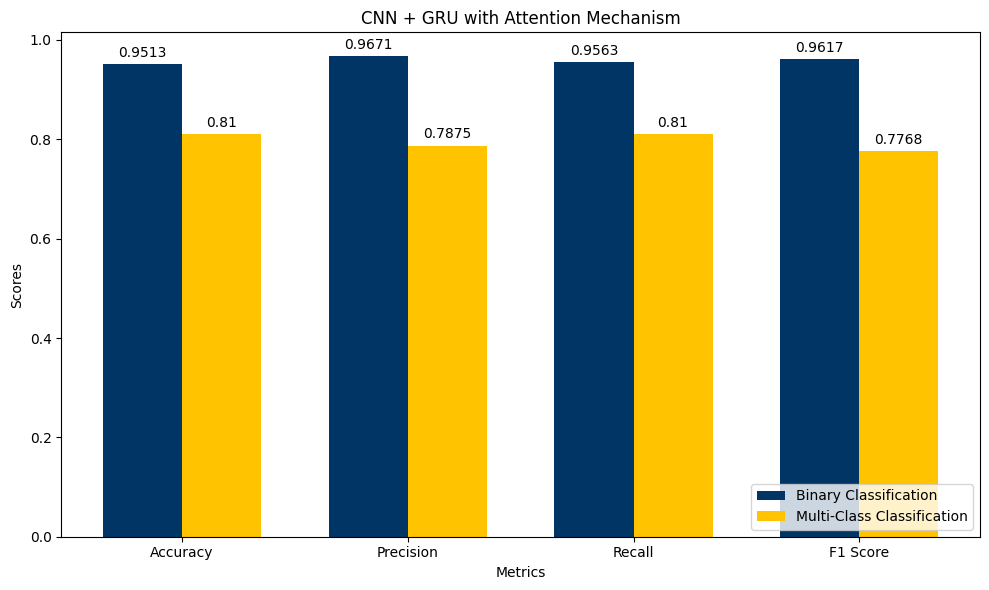

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + GRU with Attention Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+BiGRU with Attention Mechanism

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# Bidirectional GRU for sequence modeling
x = Bidirectional(GRU(50, return_sequences=True))(x)

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=2, key_dim=50)(x, x)
attention_output = Add()([x, attention_output])
attention_output = LayerNormalization()(attention_output)

# Flatten and Dense layers for classification
x = GlobalAveragePooling1D()(attention_output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiGRU_A = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])


In [ ]:
# Compile the model
modelBiGRU_A.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)


In [ ]:
# Train the model
modelBiGRU_A.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=10, batch_size=32, validation_split=0.2
)


Epoch 1/10
5154/5154 [==============================] - 217s 41ms/step - loss: 1.0520 - binary_output_loss: 0.2363 - multi_class_output_loss: 0.8157 - binary_output_accuracy: 0.8891 - multi_class_output_accuracy: 0.7011 - val_loss: 0.8057 - val_binary_output_loss: 0.1685 - val_multi_class_output_loss: 0.6372 - val_binary_output_accuracy: 0.9204 - val_multi_class_output_accuracy: 0.7616
Epoch 2/10
5154/5154 [==============================] - 208s 40ms/step - loss: 0.8196 - binary_output_loss: 0.1669 - multi_class_output_loss: 0.6527 - binary_output_accuracy: 0.9187 - multi_class_output_accuracy: 0.7585 - val_loss: 0.7071 - val_binary_output_loss: 0.1392 - val_multi_class_output_loss: 0.5680 - val_binary_output_accuracy: 0.9379 - val_multi_class_output_accuracy: 0.7844
Epoch 3/10
5154/5154 [==============================] - 209s 41ms/step - loss: 0.7510 - binary_output_loss: 0.1490 - multi_class_output_loss: 0.6021 - binary_output_accuracy: 0.9297 - multi_class_output_accuracy: 0.7760 - 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiGRU_A.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 17s 10ms/step
Binary Classification:
Accuracy: 0.9627825749490637
Precision: 0.9704704097116844
Recall: 0.9712957900492072
F1 Score: 0.9708829244595579
Confusion Matrix:
[[17640   973]
 [  945 31977]]

Multi-Class Classification:
Accuracy: 0.8266808964781217
Precision: 0.8082669808815994
Recall: 0.8266808964781217
F1 Score: 0.7955807000464119
Confusion Matrix:
[[    6     0     0   377    52     0    84     0     0     0]
 [    0     0     0   385    56     0     4    23     0     0]
 [    0     0     5  3085    96     0    42    55     9     0]
 [    1     0     0  8338   348     3   163   213    14     0]
 [    0     0     0   590  3196     0   862   172    11     0]
 [    0     0     8   241    36 11221    11    18     2     0]
 [    1     0     0   113   531     0 17879    83     6     0]
 [    0     0     1   803    73     0    93  1882     0     0]
 [    0     0     0    72    26     0    29   106    76     0]
 [    0     0     0    33

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


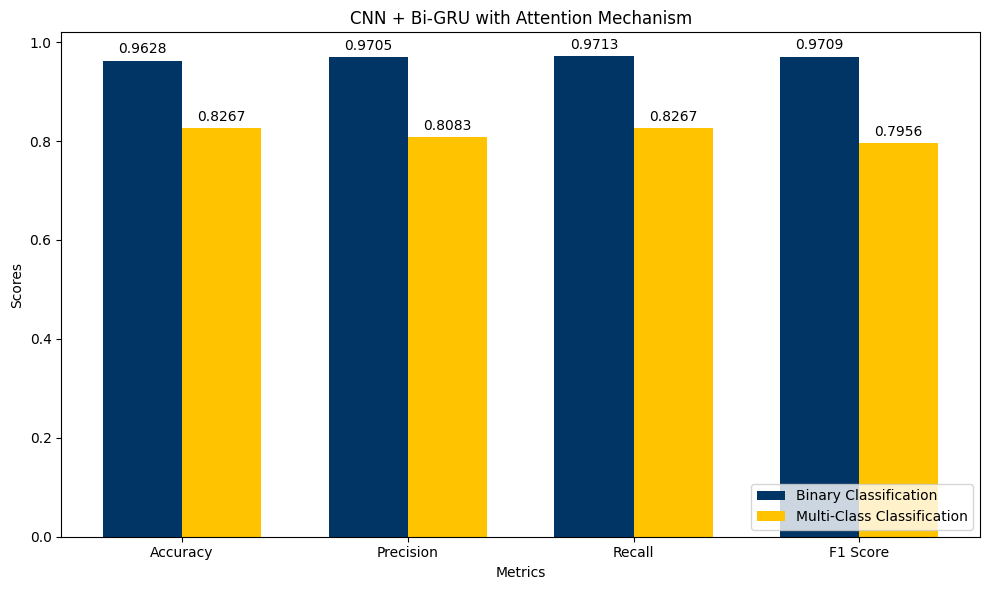

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-GRU with Attention Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + BiLSTM + Attention Mechanism 02

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# BiLSTM for sequence modeling
x = Bidirectional(LSTM(50, return_sequences=True))(x)

# Multi-head attention layer
attention_output, attention_weights = MultiHeadAttention(num_heads=8, key_dim=50)(x, x, return_attention_scores=True)
x = GlobalAveragePooling1D()(attention_output)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiLSTM_A = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
modelBiLSTM_A.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelBiLSTM_A.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=8, batch_size=32, validation_split=0.2
)

Epoch 1/8
5154/5154 [==============================] - 332s 61ms/step - loss: 1.0489 - binary_output_loss: 0.2396 - multi_class_output_loss: 0.8094 - binary_output_accuracy: 0.8887 - multi_class_output_accuracy: 0.7026 - val_loss: 0.7976 - val_binary_output_loss: 0.1638 - val_multi_class_output_loss: 0.6337 - val_binary_output_accuracy: 0.9229 - val_multi_class_output_accuracy: 0.7625
Epoch 2/8
5154/5154 [==============================] - 291s 57ms/step - loss: 0.8257 - binary_output_loss: 0.1716 - multi_class_output_loss: 0.6541 - binary_output_accuracy: 0.9201 - multi_class_output_accuracy: 0.7565 - val_loss: 0.7399 - val_binary_output_loss: 0.1455 - val_multi_class_output_loss: 0.5944 - val_binary_output_accuracy: 0.9309 - val_multi_class_output_accuracy: 0.7792
Epoch 3/8
5154/5154 [==============================] - 299s 58ms/step - loss: 0.7657 - binary_output_loss: 0.1523 - multi_class_output_loss: 0.6134 - binary_output_accuracy: 0.9309 - multi_class_output_accuracy: 0.7714 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiLSTM_A.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 28s 17ms/step
Binary Classification:
Accuracy: 0.9553507325118852
Precision: 0.9650396379430793
Recall: 0.9650689508535326
F1 Score: 0.9650542941757156
Confusion Matrix:
[[17462  1151]
 [ 1150 31772]]

Multi-Class Classification:
Accuracy: 0.8178713495682546
Precision: 0.8106555475220789
Recall: 0.8178713495682546
F1 Score: 0.7860178789319595
Confusion Matrix:
[[   35     0     0   411     9     0    62     2     0     0]
 [    0     0     0   422    15     0     2    29     0     0]
 [    0     0     1  3110    56     3    49    67     6     0]
 [    5     0     0  8545   259     1   153   113     4     0]
 [    6     0     0   814  2778     0  1112   121     0     0]
 [    0     0     1   243    40 11225    16    11     1     0]
 [   11     0     0   191   563     0 17734   110     4     0]
 [    0     0     0   905    83     1    55  1808     0     0]
 [    0     0     0   103    26     0    21   136    23     0]
 [    0     0     0    32

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


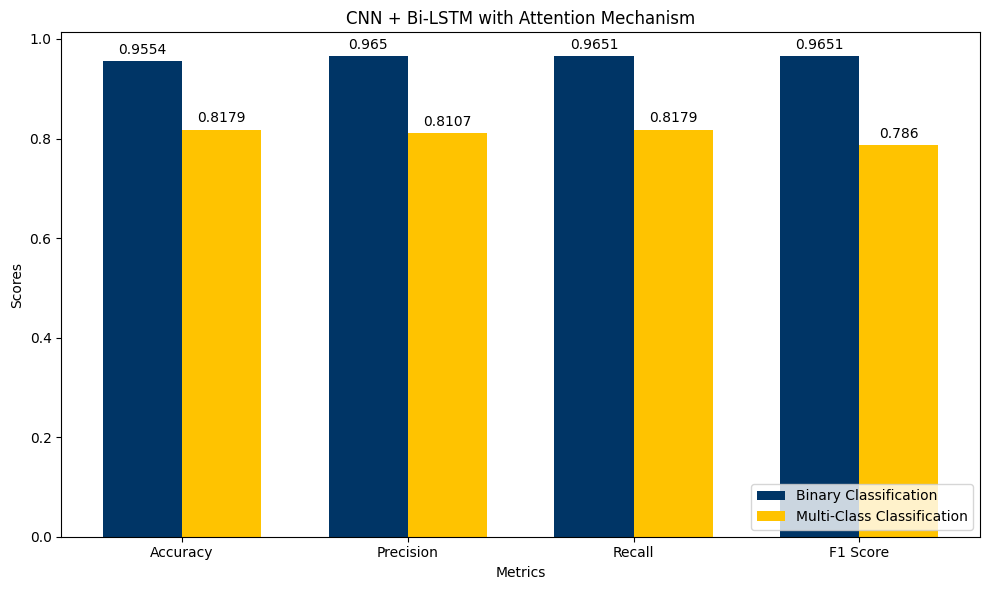

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM with Attention Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + BiGRU + Attention Mechaniam 02


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# Bidirectional GRU for sequence modeling
x = Bidirectional(GRU(50, return_sequences=True))(x)

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=2, key_dim=50)(x, x)
attention_output = Add()([x, attention_output])
attention_output = LayerNormalization()(attention_output)

# Flatten and Dense layers for classification
x = GlobalAveragePooling1D()(attention_output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiGRU_A = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])


In [ ]:
# Compile the model
modelBiGRU_A.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelBiGRU_A.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=8, batch_size=32, validation_split=0.2
)


Epoch 1/8
5154/5154 [==============================] - 206s 39ms/step - loss: 1.0562 - binary_output_loss: 0.2381 - multi_class_output_loss: 0.8181 - binary_output_accuracy: 0.8894 - multi_class_output_accuracy: 0.6988 - val_loss: 0.8022 - val_binary_output_loss: 0.1642 - val_multi_class_output_loss: 0.6379 - val_binary_output_accuracy: 0.9197 - val_multi_class_output_accuracy: 0.7568
Epoch 2/8
5154/5154 [==============================] - 194s 38ms/step - loss: 0.8086 - binary_output_loss: 0.1646 - multi_class_output_loss: 0.6440 - binary_output_accuracy: 0.9204 - multi_class_output_accuracy: 0.7603 - val_loss: 0.7197 - val_binary_output_loss: 0.1416 - val_multi_class_output_loss: 0.5781 - val_binary_output_accuracy: 0.9344 - val_multi_class_output_accuracy: 0.7798
Epoch 3/8
5154/5154 [==============================] - 195s 38ms/step - loss: 0.7493 - binary_output_loss: 0.1489 - multi_class_output_loss: 0.6004 - binary_output_accuracy: 0.9298 - multi_class_output_accuracy: 0.7760 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiGRU_A.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 [==============================] - 18s 10ms/step
Binary Classification:
Accuracy: 0.9596196759483846
Precision: 0.9783478611533332
Recall: 0.9579916165482049
F1 Score: 0.9680627388388403
Confusion Matrix:
[[17915   698]
 [ 1383 31539]]

Multi-Class Classification:
Accuracy: 0.8223731444649267
Precision: 0.796966780335171
Recall: 0.8223731444649267
F1 Score: 0.788690002702654
Confusion Matrix:
[[    0     0     0   414    24     0    81     0     0     0]
 [    0     0     0   402    38     0    10    18     0     0]
 [    0     0     8  3103    66     0    59    50     6     0]
 [    0     0     0  8461   245     2   220   143     9     0]
 [    0     0     0   710  2834     0  1187    90    10     0]
 [    0     0     8   238    39 11219    23    10     0     0]
 [    0     0     1   116   346     0 18128    20     2     0]
 [    0     0     6   897    90     0   190  1669     0     0]
 [    0     0     0    46    49     0    51   101    62     0]
 [    0     0     0    34  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


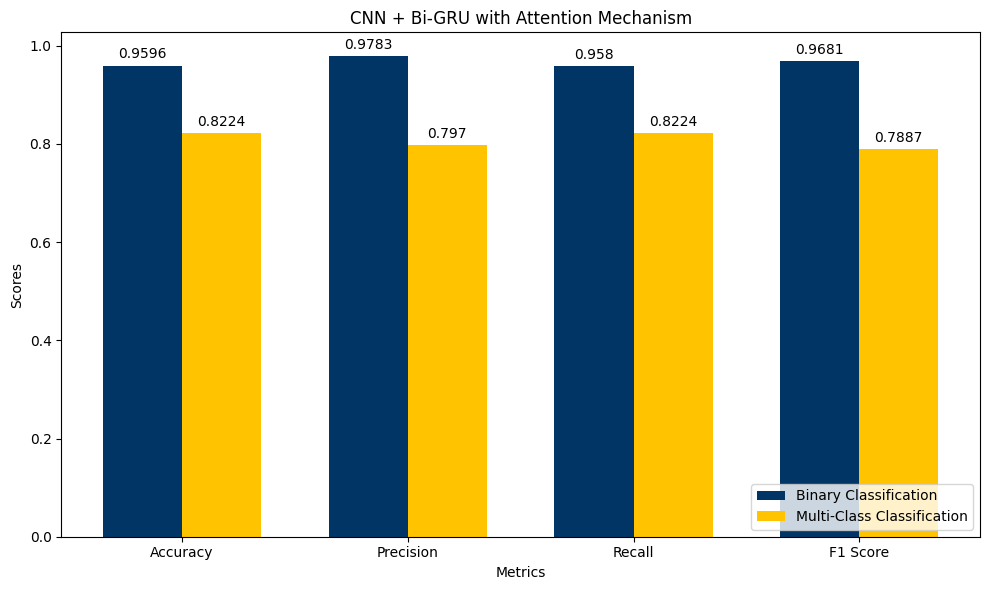

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-GRU with Attention Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()